In [1]:
from math import remainder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost.dask import predict
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
import pickle
df_csv = pd.read_csv("zomato.csv", encoding='latin-1')
df2=pd.read_excel("Country-Code.xlsx")
print(df_csv.shape)
df_csv.dropna (inplace=True)
merged=pd.merge(df_csv,df2,on='Country Code',how='left')
print(merged.shape)

(9551, 21)
(9542, 22)


In [2]:
#find how many restaurants in country india
indian_restaurant=merged[merged['Country']=='Canada']
print(indian_restaurant.shape[0])

4


In [3]:
print(merged['Country'].value_counts())
print(merged['City'].nunique())
cities=merged['City']
print(cities.value_counts())


Country
India             8652
United States      425
United Kingdom      80
Brazil              60
UAE                 60
South Africa        60
New Zealand         40
Turkey              34
Australia           24
Phillipines         22
Indonesia           21
Singapore           20
Qatar               20
Sri Lanka           20
Canada               4
Name: count, dtype: int64
140
City
New Delhi         5473
Gurgaon           1118
Noida             1080
Faridabad          251
Ghaziabad           25
                  ... 
Lincoln              1
Lakeview             1
Lakes Entrance       1
Inverloch            1
Panchkula            1
Name: count, Length: 140, dtype: int64


In [4]:
filtered=merged[(merged['City']=='Ghaziabad')&(merged['Rating text']=='Good')]
print(filtered.shape)
merged['Rating text'].unique()

(4, 22)


array(['Excellent', 'Very Good', 'Good', 'Average', 'Not rated', 'Poor'],
      dtype=object)

Country
India             116
United States      67
United Kingdom     23
UAE                18
Brazil             16
Name: count, dtype: int64


<Axes: xlabel='Country'>

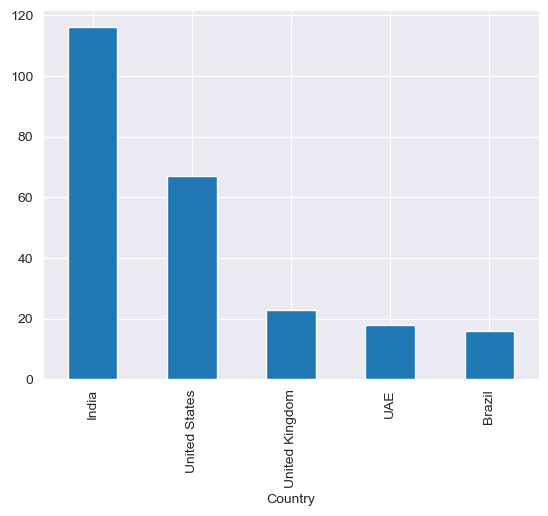

In [5]:
#top 5 country jinki rating excellent hai usko bar graph me krna h
"""import matplotlib.pyplot as plt"""
excellent_rating=merged[merged['Rating text']=='Excellent']
top_5=excellent_rating['Country'].value_counts().head(5)
print(top_5)
top_5.plot(kind='bar')

In [6]:


data = pd.read_csv('quikr_car.csv')

#duplicate hata diye
data.dropna(inplace=True)
data = data[data['year'].str.isnumeric()]
data['year'] = data['year'].astype(int)
data = data[data['Price'] != 'Ask For Price']
data['Price'] = data['Price'].str.replace(',', '').astype(int)
data = data[data['Price'] > 0]
data['kms_driven'] = data['kms_driven'].str.split(' ').str.get(0).str.replace(',', '')
data = data[data['kms_driven'].str.isnumeric()]
data['kms_driven'] = data['kms_driven'].astype(int)
print(data.info())


data['name']=data['name'].str.split(" ").str.slice(0,3).str.join(" ")
data.reset_index(inplace=True)
data.to_csv('cleaned_quikr_car_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 816 entries, 0 to 889
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        816 non-null    object
 1   company     816 non-null    object
 2   year        816 non-null    int64 
 3   Price       816 non-null    int64 
 4   kms_driven  816 non-null    int64 
 5   fuel_type   816 non-null    object
dtypes: int64(3), object(3)
memory usage: 44.6+ KB
None


In [7]:
print(data['name'].nunique())
print(data['company'].nunique())
data['fuel_type'].nunique()
#now we need to use one hot encoding for name , company and fuel type
ohe=OneHotEncoder(handle_unknown='ignore')



254
25


Model Building


In [8]:
# Drop the unnecessary 'index' column that was created during reset_index
if 'index' in data.columns:
    data = data.drop('index', axis=1)

# Remove outliers using IQR method for better model performance
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['Price'] >= Q1 - 1.5 * IQR) & (data['Price'] <= Q3 + 1.5 * IQR)]

x = data.drop('Price', axis=1)
y = data['Price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Create column transformer with OHE and scaling
columns_transform = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), ['name', 'company', 'fuel_type']),
    ('scaler', StandardScaler(), ['year', 'kms_driven'])
])

# Try multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, max_depth=10)
}

results = {}
for name, model in models.items():
    pipe = make_pipeline(columns_transform, model)
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    score = r2_score(y_test, y_pred)
    results[name] = score
    print(f'{name}: R² Score = {score:.4f}')

# Use the best model
best_model_name = max(results, key=results.get)
print(f'\nBest Model: {best_model_name} with R² Score: {results[best_model_name]:.4f}')

# Train final model with best performer
final_pipe = make_pipeline(columns_transform, models[best_model_name])
final_pipe.fit(x_train, y_train)
y_pred = final_pipe.predict(x_test)
print(f'\nFinal Model R² Score: {r2_score(y_test, y_pred):.4f}')
with open('final_pipe.pkl', 'wb') as f:
    pickle.dump(final_pipe, f)

# Save the 'x' dataframe (pre-split) for dropdown options in the app
with open('data_features.pkl', 'wb') as f:
    pickle.dump(x, f)


Linear Regression: R² Score = 0.7959
Random Forest: R² Score = 0.7011
Gradient Boosting: R² Score = 0.6985
XGBoost: R² Score = 0.7854

Best Model: Linear Regression with R² Score: 0.7959

Final Model R² Score: 0.7959


In [ ]:
#dump this and make a streamlit webapp
